#  COMMUNITY DETECTION - PART I:
### Trying to obtain good parameters for the network based on a sample of the Polboks dataset.

This experiment used Supervised Learning and Graph Convolutional Networks. <br> <br>
Based on the [tutorial](https://docs.dgl.ai/tutorials/basics/1_first.html), I tried to create a model for  Community Detection in the [Poolbooks]("http://www-personal.umich.edu/~mejn/netdata/polbooks.zip") dataset (see the description below).

> Books about US politics
Compiled by Valdis Krebs
Nodes represent books about US politics sold by the online bookseller
Amazon.com.  Edges represent frequent co-purchasing of books by the same
buyers, as indicated by the "customers who bought this book also bought
these other books" feature on Amazon.
Nodes have been given values "l", "n", or "c" to indicate whether they are
"liberal", "neutral", or "conservative".  These alignments were assigned
separately by Mark Newman based on a reading of the descriptions and
reviews of the books posted on Amazon.
Source: V. Krebs, unpublished, http://www.orgnet.com/. 

At first, I tried to train the whole dataset (see "Part_II_Community_Detection_Polbooks.ipynb") but I struggled with finding the correct model settings (eg. the number of hidden layers and the size of the layers). In an attempt to solve this problem, I extracted a sample from this dataset -  12 nodes and 25 edges - with original connections. The best parameters were obtained through many trial and error attempts. <br>
The accuracy of this model oscillated between 9-10 correctly assigned nodes (out of 12) in most of the cases.

In [271]:
%matplotlib inline

In [272]:
import dgl
import numpy as np

In [273]:
try:  # Python 3.x
    import urllib.request as urllib
except ImportError:  # Python 2.x
    import urllib
import io
import zipfile

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx


In [274]:
f = open("sample_polbooks.gml", "r")
gml = f.read()
g = nx.parse_gml(gml)

for node in g.nodes(data='value'):
    print(node)
    
NUMBER_OF_NODES = g.number_of_nodes()
NUMBER_OF_EDGES = g.number_of_edges()
print("\n Number of nodes: ", NUMBER_OF_NODES, " Number of edges: ", NUMBER_OF_EDGES)

('Allies', 'c')
('Bush Country', 'c')
('The French Betrayal of America', 'c')
('Surprise, Security, the American Experience', 'n')
('Rise of the Vulcans', 'c')
('America Unbound', 'l')
('The Choice', 'l')
('The Great Unraveling', 'l')
('Rogue Nation', 'l')
('Soft Power', 'l')
('Colossus', 'n')
('The Sorrows of Empire', 'l')

 Number of nodes:  12  Number of edges:  25


In [275]:
LIBERAL = 0
CONSERVATIVE = 1
NEUTRAL = 2
CATEGORY_IDX = 1

In [276]:
CATEGORIES_MAPPING = {'l' : 0, 'c' : 1, 'n' : 2}
def map_categories_to_nums(graph_values):
    return [CATEGORIES_MAPPING[el[CATEGORY_IDX]] for el in graph_values]

In [277]:
COLORS_MAPPING = {LIBERAL: "blue", CONSERVATIVE: "red", NEUTRAL: "green"}
def map_categories_to_colors(categories_list):
    return [COLORS_MAPPING[el] for el in categories_list]

In [278]:
graph_values = g.nodes.data('value')
categorized_nodes = map_categories_to_nums(graph_values)

In [279]:
print(categorized_nodes)

[1, 1, 1, 2, 1, 0, 0, 0, 0, 0, 2, 0]


In [280]:
node_colors = map_categories_to_colors(categorized_nodes)

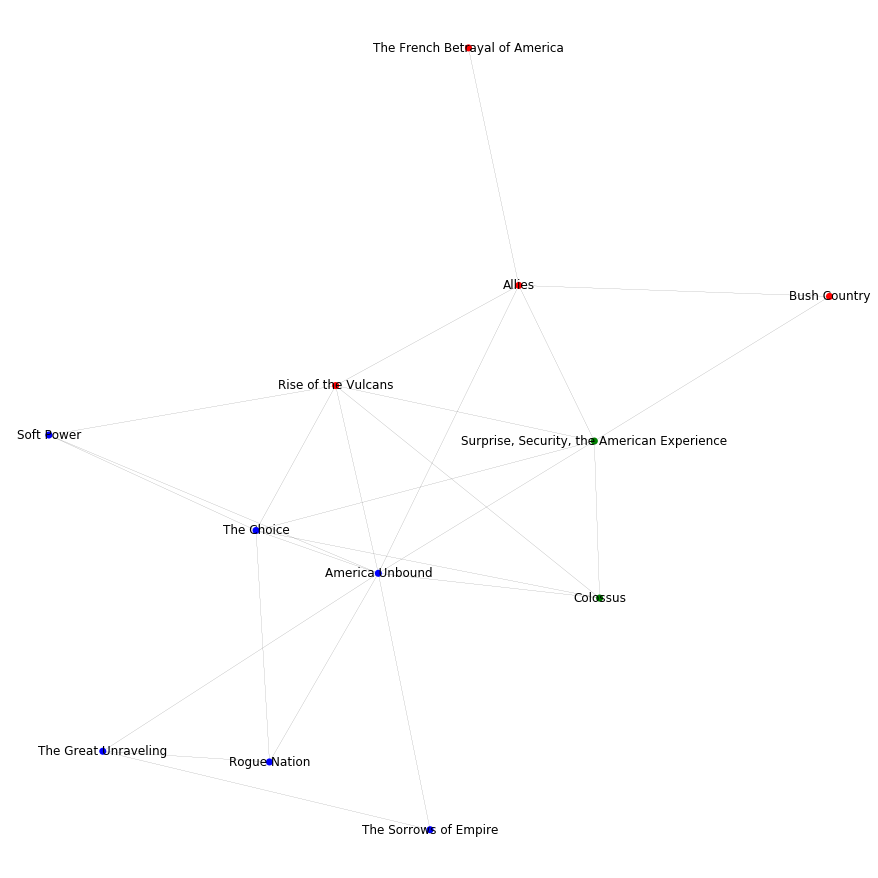

In [281]:
options = {
    'node_color':  node_colors,
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
    'with_labels': True,
    'pos': nx.kamada_kawai_layout(g)
}
plt.figure(3,figsize=(12,12)) 
nx.draw(g, **options)
plt.show()

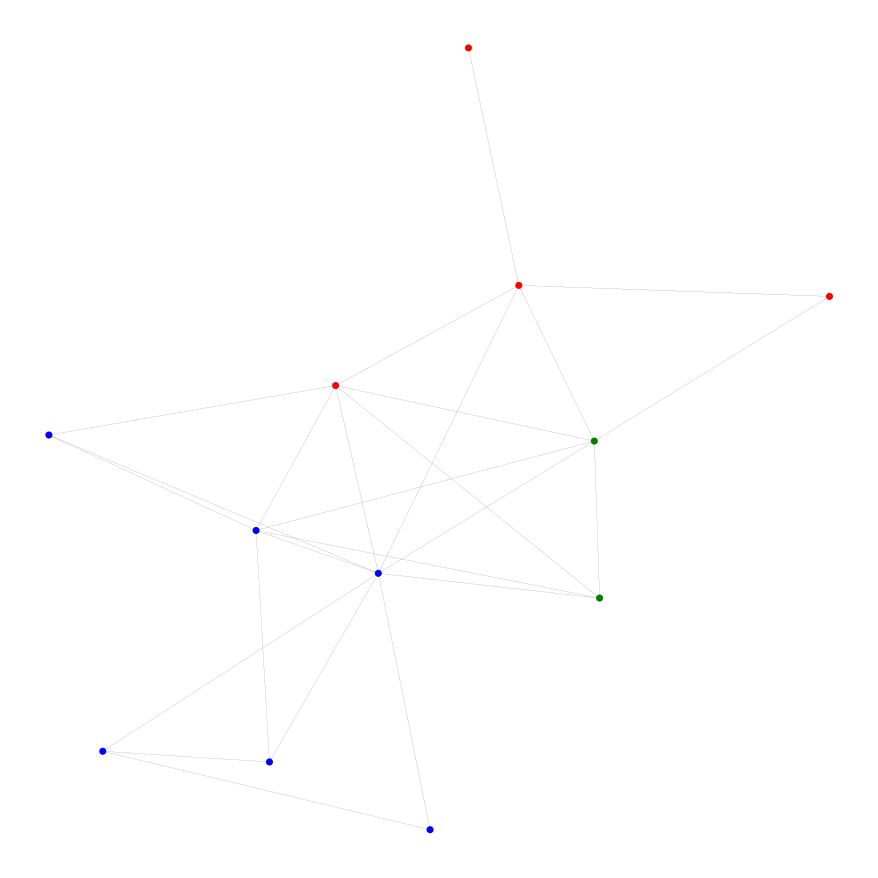

In [282]:
options = {
    'node_color':  node_colors,
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
    'with_labels': False,
    'pos': nx.kamada_kawai_layout(g)
}
plt.figure(3,figsize=(12,12)) 
nx.draw(g, **options)
plt.show()

In [283]:
nx.is_directed(g)

False

In [284]:
G = dgl.DGLGraph()
G.from_networkx(g)

In [285]:
import torch
import torch.nn as nn
import torch.nn.functional as F


embed = nn.Embedding(NUMBER_OF_NODES, 18)
G.ndata['feat'] = embed.weight

In [286]:
from dgl.nn.pytorch import GraphConv

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, hidden_size_1, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, hidden_size_1)
        self.conv3 = GraphConv(hidden_size_1, num_classes)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        h = torch.relu(h)
        h = self.conv3(g, h)
        return h

# The first layer transforms input features of size of 5 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(18, 9, 6, 3)

In [288]:
def get_nodes_with_category(nodes, category):
    return [i for i, el in enumerate(nodes) if el == category]

In [289]:
liberal_nodes = get_nodes_with_category(categorized_nodes, LIBERAL)
conservative_nodes = get_nodes_with_category(categorized_nodes, CONSERVATIVE)
neutral_nodes = get_nodes_with_category(categorized_nodes, NEUTRAL)
print(len(liberal_nodes), len(conservative_nodes), len(neutral_nodes))

6 4 2


In [290]:
import random

def sample_n_nodes(dataset, n, category):
    books_within_category = get_nodes_with_category(dataset, category)
    
    random.shuffle(books_within_category)
    books_within_category = books_within_category[:n]
    labels = [category] * len(books_within_category)
    return torch.Tensor(books_within_category).long(), torch.Tensor(labels).long()

In [291]:
sample_liberal_nodes, sample_liberal_labels = sample_n_nodes(categorized_nodes, 3, LIBERAL)
sample_conservative_nodes, sample_conservative_labels = sample_n_nodes(categorized_nodes, 2, CONSERVATIVE)
sample_neutral_nodes, sample_neutral_labels = sample_n_nodes(categorized_nodes, 2, NEUTRAL)

In [292]:
inputs = embed.weight

labeled_nodes = torch.cat((sample_liberal_nodes, sample_conservative_nodes, sample_neutral_nodes), 0)
labels = torch.cat((sample_liberal_labels, sample_conservative_labels, sample_neutral_labels), 0)
print(labeled_nodes, labels)

tensor([ 7,  6,  9,  2,  1, 10,  3]) tensor([0, 0, 0, 1, 1, 2, 2])


In [293]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(80):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 1.1313
Epoch 1 | Loss: 1.1058
Epoch 2 | Loss: 1.0864
Epoch 3 | Loss: 1.0712
Epoch 4 | Loss: 1.0567
Epoch 5 | Loss: 1.0417
Epoch 6 | Loss: 1.0286
Epoch 7 | Loss: 1.0181
Epoch 8 | Loss: 1.0086
Epoch 9 | Loss: 1.0005
Epoch 10 | Loss: 0.9939
Epoch 11 | Loss: 0.9870
Epoch 12 | Loss: 0.9786
Epoch 13 | Loss: 0.9693
Epoch 14 | Loss: 0.9587
Epoch 15 | Loss: 0.9467
Epoch 16 | Loss: 0.9339
Epoch 17 | Loss: 0.9216
Epoch 18 | Loss: 0.9104
Epoch 19 | Loss: 0.8995
Epoch 20 | Loss: 0.8892
Epoch 21 | Loss: 0.8795
Epoch 22 | Loss: 0.8708
Epoch 23 | Loss: 0.8616
Epoch 24 | Loss: 0.8522
Epoch 25 | Loss: 0.8427
Epoch 26 | Loss: 0.8323
Epoch 27 | Loss: 0.8213
Epoch 28 | Loss: 0.8101
Epoch 29 | Loss: 0.7988
Epoch 30 | Loss: 0.7875
Epoch 31 | Loss: 0.7761
Epoch 32 | Loss: 0.7641
Epoch 33 | Loss: 0.7509
Epoch 34 | Loss: 0.7370
Epoch 35 | Loss: 0.7230
Epoch 36 | Loss: 0.7091
Epoch 37 | Loss: 0.6949
Epoch 38 | Loss: 0.6800
Epoch 39 | Loss: 0.6637
Epoch 40 | Loss: 0.6479
Epoch 41 | Loss: 0.6324
Ep

In [294]:
def draw(i):
    pos = {}
    colors = []
    classification= []
    for v in range(NUMBER_OF_NODES):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        classification.append(cls)
        colors.append(COLORS_MAPPING[cls])
    options = {
    'node_color':  colors,
    'node_size': 50,
    'line_color': 'grey',
    'linewidths': 0,
    'width': 0.1,
    'with_labels': True,
    'pos': nx.kamada_kawai_layout(g)
    }
    plt.figure(3,figsize=(12,12)) 
    nx.draw(g, **options)
    return classification

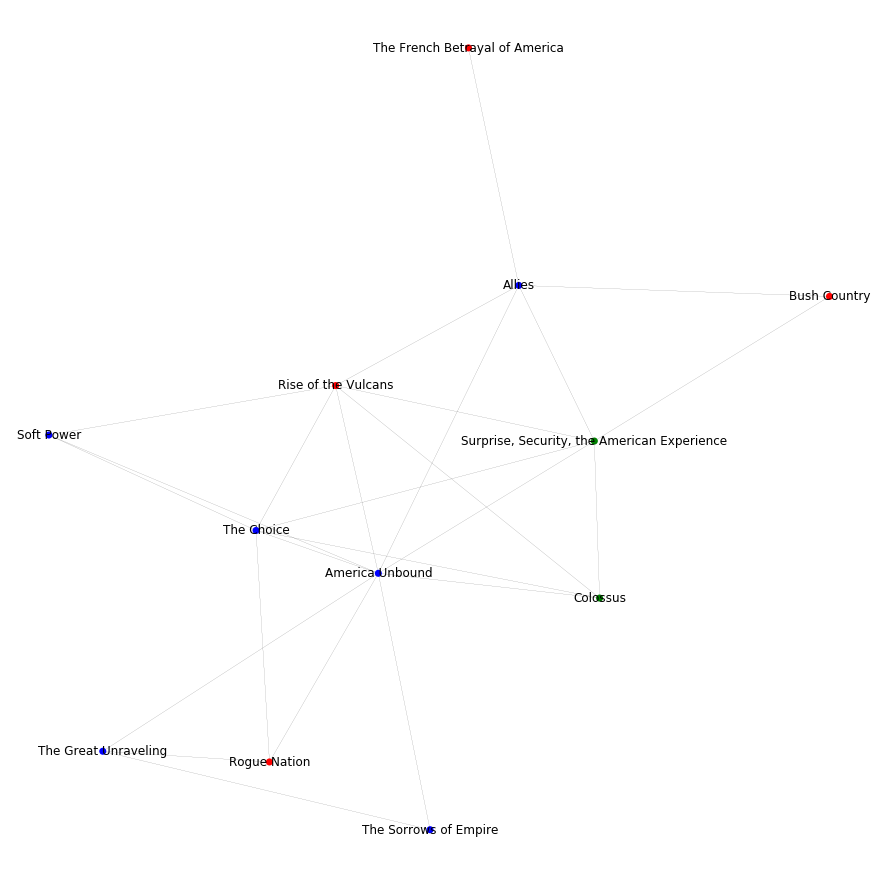

In [295]:
result = draw(79)

In [296]:
def print_correctly_assigned(categorized_nodes, result):
    from operator import sub
    correctly_assigned = list(map(sub, categorized_nodes, result)).count(0)
    return "Correctly assigned: " + str(correctly_assigned) + "/" + str(NUMBER_OF_NODES)

In [297]:
print_correctly_assigned(categorized_nodes, result)

'Correctly assigned: 10/12'